### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

### Parameters

In [2]:
UPDATED_DATE = '4/21/20'

### Original Datasets

In [3]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/time_series_global_confirmed.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/time_series_global_deaths.csv')
population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/population.csv')
life_expectancy = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/life_expectancy.csv')
median_age = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/median_age.csv')
total_gdp_ppp = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_GDP(PPP).csv')
smoking = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/smoking(%25).csv')
population_over_60_years = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/population_over_60%20(%25%20of%20population).csv')
rural_population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/rural_population(%25).csv')
urban_population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/urban_population(%25).csv')
hospital_beds_per_1000 = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/hospital_beds_per_1000.csv')
healthcare_expenditure = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/health_expenditure%20(%25%20of%20GDP).csv')
govt_health_expenditure_per_capita = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/government_health_spending_per_person%20(PPP).csv')
total_health_expenditure_per_capita = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_health_spending_per_capita(PPP).csv')
access_to_sanitation_facilities = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_basic_sanitation_facilities%20(%25%20of%20population).csv')


### Countries Dataset

In [4]:
countries = pd.DataFrame()

### Grouping by Country (combining states / counties)

In [5]:
def group(df):
    df = df.drop(columns=['Lat','Long'])
    df = pd.DataFrame(df.groupby(by = 'Country/Region').sum())
    return df

confirmed = group(confirmed)
deaths = group(deaths)

### Adding Growth Rate and Mortality

In [6]:
def find_overall_growth_rate_by_day(df):
    old_df = df
    new_df = {}

    for i, n in enumerate(old_df.index):
        t = np.count_nonzero(old_df.iloc[i])
        if t:    new_df[n] = (old_df.iloc[i][-1] / old_df.iloc[i][-t])**(1/t) - 1 # using the compound interest formula 
        else:    new_df[n] = 0

    return pd.Series(new_df) * 100
        

def find_mortality():
    return np.divide(countries['deaths'], countries['confirmed']) * 100


### Adding Additional Demographic Information 

In [7]:
def find_most_recent(df):
    df.index = df['country']
    cols = list(reversed(df.columns))
    while int(cols[0]) > 2020: cols.pop(0)

    data = {}
    
    for i in df.index:
        for j in cols:
            if not np.isnan(df.loc[i][j]):
                data[i] = df.loc[i][j]
                break

    return data


def match_countries(df):
    d = find_most_recent(df)
    
    replace = {
        'Cabo Verde': 'Cape Verde',
        'Congo (Brazzaville)': 'Congo, Rep.',
        'Congo (Kinshasa)': 'Congo, Dem. Rep.',
        'Czechia': 'Czech Republic',
        'Korea, South': 'South Korea',
        'Laos': 'Lao',
        'Saint Kitts and Nevis': 'St. Kitts and Nevis',
        'Saint Lucia': 'St. Lucia',
        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
        'US': 'United States',
        'West Bank and Gaza': 'Palestine',
    }
    
    values = []
    for i in countries.index:
        if i in replace: i = replace[i]
            
        if d.get(i, None) != None:
            values.append(d[i])
        else:
            values.append(None)
    
    return values

In [8]:
countries['confirmed'] = confirmed[UPDATED_DATE]
countries['deaths'] = deaths[UPDATED_DATE]
countries['confirmed_growth_rate'] = find_overall_growth_rate_by_day(confirmed)
countries['deaths_growth_rate'] = find_overall_growth_rate_by_day(deaths)
countries['mortality'] = find_mortality()
countries['population'] = match_countries(population)
countries['life_expectancy'] = match_countries(life_expectancy)
countries['median_age'] = match_countries(median_age)
countries['total_gdp_ppp'] = match_countries(total_gdp_ppp)
countries['smoking'] = match_countries(smoking)
countries['population_over_60_years'] = match_countries(population_over_60_years)
countries['hospital_beds_per_1000'] = match_countries(hospital_beds_per_1000)
countries['healthcare_expenditure'] = match_countries(healthcare_expenditure)
countries['govt_health_expenditure_per_capita'] = match_countries(govt_health_expenditure_per_capita)
countries['total_health_expenditure_per_capita'] = match_countries(total_health_expenditure_per_capita)
countries['access_to_sanitation_facilities'] = match_countries(access_to_sanitation_facilities)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


### Dropping Redundant Tuples

In [9]:
# Deleting columns that do not pertain to countries and instead correspond to cruise ships:
# -> Diamond Princess
# -> MS Zaandam
countries = countries.drop(index=['Diamond Princess', 'MS Zaandam'])

### Imputing Missing Data and Correcting Zero Division Errors

In [10]:
countries = countries.apply(lambda x: x.replace(float('inf'), 0))

from sklearn.impute import SimpleImputer
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_countries = pd.DataFrame(impute.fit_transform(countries))
imputed_countries.index = countries.index
imputed_countries.columns = countries.columns
countries = imputed_countries

In [11]:
countries['GDP/Capita'] = countries['total_gdp_ppp'] / countries['population']
countries['Cases/100000'] = (countries['confirmed'] * 100000) / countries['population']
countries['Deaths/100000'] = (countries['deaths'] * 100000) / countries['population']

### Scaling the data before Clustering to prevent skewing of clustering results

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(np.array(countries[['Cases/100000', 'Deaths/100000', 'confirmed_growth_rate', 'deaths_growth_rate', 'mortality']]))

### Running K-Means Clustering with 3 clusters

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
result = kmeans.predict(data)

### Evaluating K Means Clustering using the Silhouette Coefficient 

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score(data, result, metric='euclidean')

0.32727813901767205

### Visualizing the Resulting Clusters 

In [15]:
countries['class'] = kmeans.predict(data)

In [16]:
countries[countries['class'] == 0]

,confirmed,deaths,confirmed_growth_rate,deaths_growth_rate,mortality,population,life_expectancy,median_age,total_gdp_ppp,smoking,population_over_60_years,hospital_beds_per_1000,healthcare_expenditure,govt_health_expenditure_per_capita,total_health_expenditure_per_capita,access_to_sanitation_facilities,GDP/Capita,Cases/100000,Deaths/100000,class
Country/Region,,,,,,,,,,,,,,,,,,,,
Afghanistan,1092.0,36.0,12.819235,12.254383,3.296703,38900000.0,64.4,18.6,6.580000e+10,21.30597,4.28,0.5,10.20,5.18,44.5,43.4,1691.516710,2.807198,0.092545,0
Algeria,2811.0,392.0,14.949300,15.678029,13.945215,43900000.0,78.3,29.1,4.790000e+11,15.60000,10.10,1.9,6.65,257.00,330.0,87.6,10911.161731,6.403189,0.892938,0
Argentina,3031.0,147.0,17.390167,11.728150,4.849885,45200000.0,77.1,31.9,7.310000e+11,21.80000,15.90,5.0,7.55,703.00,1290.0,94.3,16172.566372,6.705752,0.325221,0
Armenia,1401.0,24.0,14.949854,12.491300,1.713062,2960000.0,76.0,35.7,2.340000e+10,24.10000,18.80,4.2,9.93,96.90,239.0,93.6,7905.405405,47.331081,0.810811,0
Austria,14873.0,491.0,16.928061,16.315110,3.301284,9010000.0,82.1,44.4,3.640000e+11,29.60000,26.50,7.6,10.40,3400.00,4390.0,100.0,40399.556049,165.072142,5.449501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,6125.0,161.0,19.053487,13.545688,2.628571,43700000.0,70.9,41.4,3.730000e+11,28.90000,24.00,8.8,6.73,294.00,519.0,96.2,8535.469108,14.016018,0.368421,0
United Kingdom,130172.0,17378.0,14.472474,22.555648,13.350029,67900000.0,81.2,40.8,2.220000e+12,22.30000,24.80,2.8,9.76,2920.00,3480.0,99.1,32695.139912,191.711340,25.593520,0
Uruguay,535.0,11.0,13.375797,10.507400,2.056075,3470000.0,77.5,35.6,6.350000e+10,16.80000,20.20,2.8,9.06,797.00,1190.0,96.6,18299.711816,15.417867,0.317003,0


In [17]:
countries[countries['class'] == 1]

,confirmed,deaths,confirmed_growth_rate,deaths_growth_rate,mortality,population,life_expectancy,median_age,total_gdp_ppp,smoking,population_over_60_years,hospital_beds_per_1000,healthcare_expenditure,govt_health_expenditure_per_capita,total_health_expenditure_per_capita,access_to_sanitation_facilities,GDP/Capita,Cases/100000,Deaths/100000,class
Country/Region,,,,,,,,,,,,,,,,,,,,
Albania,609.0,26.0,13.879399,8.066190,4.269294,2.880000e+06,78.600000,38.000000,3.070000e+10,28.70000,21.100000,2.900000,6.700000,225.000000,577.000000,97.700000,10659.722222,21.145833,0.902778,1
Angola,24.0,2.0,10.109447,0.000000,8.333333,3.290000e+07,65.400000,16.800000,1.520000e+11,21.30597,4.150000,0.800000,2.880000,139.000000,168.000000,49.900000,4620.060790,0.072948,0.006079,1
Antigua and Barbuda,23.0,3.0,8.154152,7.598962,13.043478,9.790000e+04,77.400000,32.100000,1.830000e+09,21.30597,12.200000,3.800000,4.310000,703.000000,991.000000,87.500000,18692.543412,23.493361,3.064351,1
Australia,6547.0,67.0,8.878549,8.421852,1.023369,2.550000e+07,82.800000,37.900000,9.940000e+11,14.70000,21.900000,3.800000,9.250000,2340.000000,3440.000000,100.000000,38980.392157,25.674510,0.262745,1
Azerbaijan,1480.0,20.0,12.665556,7.776915,1.351351,1.010000e+07,71.200000,32.400000,1.590000e+11,20.80000,11.700000,4.700000,6.890000,118.000000,579.000000,92.500000,15742.574257,14.653465,0.198020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,466.0,4.0,10.420182,5.268520,0.858369,5.100000e+06,77.300000,20.400000,1.690000e+10,21.30597,4.830000,1.200000,6.479825,778.905872,1126.805233,96.900000,3313.725490,9.137255,0.078431,1
Western Sahara,6.0,0.0,2.413760,0.000000,0.000000,4.342589e+07,73.840351,30.394083,5.501071e+11,21.30597,13.260355,2.900116,6.479825,778.905872,1126.805233,75.576914,12667.720981,0.013817,0.000000,1
Yemen,1.0,0.0,0.000000,0.000000,0.000000,2.980000e+07,68.200000,20.300000,1.090000e+11,18.40000,4.690000,0.700000,5.600000,29.500000,122.000000,59.100000,3657.718121,0.003356,0.000000,1


In [18]:
countries[countries['class'] == 2]

,confirmed,deaths,confirmed_growth_rate,deaths_growth_rate,mortality,population,life_expectancy,median_age,total_gdp_ppp,smoking,population_over_60_years,hospital_beds_per_1000,healthcare_expenditure,govt_health_expenditure_per_capita,total_health_expenditure_per_capita,access_to_sanitation_facilities,GDP/Capita,Cases/100000,Deaths/100000,class
Country/Region,,,,,,,,,,,,,,,,,,,,
Andorra,717.0,37.0,13.760259,12.353641,5.160391,77300.0,82.700000,30.394083,2.730000e+09,33.50000,13.260355,2.500000,10.400000,2280.000000,3260.000000,100.000000,3.531695e+04,927.554981,47.865459,2
Belgium,40956.0,5998.0,14.586189,19.837435,14.644985,11600000.0,81.900000,41.800000,4.250000e+11,28.20000,25.500000,6.200000,10.000000,3010.000000,4030.000000,99.500000,3.663793e+04,353.068966,51.706897,2
France,159297.0,20829.0,13.519223,15.999933,13.075576,65300000.0,83.200000,42.000000,2.300000e+12,32.70000,26.700000,6.500000,11.500000,3130.000000,4020.000000,98.700000,3.522205e+04,243.946401,31.897397,2
Holy See,9.0,0.0,4.785944,0.000000,0.000000,809.0,73.840351,30.394083,5.501071e+11,21.30597,13.260355,2.900116,6.479825,778.905872,1126.805233,75.576914,6.799840e+08,1112.484549,0.000000,2
Italy,183957.0,24648.0,14.956295,18.031091,13.398783,60500000.0,83.600000,47.900000,1.970000e+12,23.70000,30.700000,3.400000,8.940000,2350.000000,3020.000000,98.800000,3.256198e+04,304.061157,40.740496,2
San Marino,476.0,40.0,11.862305,7.656734,8.403361,33900.0,73.840351,30.394083,1.060000e+09,21.30597,13.260355,3.800000,6.400000,2440.000000,2850.000000,100.000000,3.126844e+04,1404.129794,117.994100,2
Spain,204178.0,21282.0,16.293560,22.056314,10.423258,46800000.0,83.500000,45.500000,1.450000e+12,29.30000,27.000000,3.000000,8.970000,2200.000000,3030.000000,99.900000,3.098291e+04,436.277778,45.474359,2


In [19]:
countries.groupby(by="class").mean()

,confirmed,deaths,confirmed_growth_rate,deaths_growth_rate,mortality,population,life_expectancy,median_age,total_gdp_ppp,smoking,population_over_60_years,hospital_beds_per_1000,healthcare_expenditure,govt_health_expenditure_per_capita,total_health_expenditure_per_capita,access_to_sanitation_facilities,GDP/Capita,Cases/100000,Deaths/100000
class,,,,,,,,,,,,,,,,,,,
0,21512.154762,1165.714286,16.629314,14.420746,4.139196,5.652350e+07,75.337385,33.066596,7.250353e+11,21.666187,15.991671,3.128573,7.144043,1017.509475,1462.967919,80.654487,1.935960e+04,69.550947,2.690933
1,1779.467391,67.543478,10.012515,3.379091,3.062168,3.276796e+07,71.976773,27.349357,3.594318e+11,20.532836,10.148517,2.604575,5.684983,444.348618,673.687468,69.381755,1.239911e+04,16.053742,0.284147
2,84227.142857,10404.857143,12.823397,13.705021,9.300908,2.633029e+07,80.368672,38.340321,9.569853e+11,27.144563,21.383009,4.042874,8.955689,2312.700839,3048.115033,96.068131,9.716943e+07,683.074803,47.954101


In [20]:
countries[countries['deaths_growth_rate'] > 20]

,confirmed,deaths,confirmed_growth_rate,deaths_growth_rate,mortality,population,life_expectancy,median_age,total_gdp_ppp,smoking,population_over_60_years,hospital_beds_per_1000,healthcare_expenditure,govt_health_expenditure_per_capita,total_health_expenditure_per_capita,access_to_sanitation_facilities,GDP/Capita,Cases/100000,Deaths/100000,class
Country/Region,,,,,,,,,,,,,,,,,,,,
Brazil,43079.0,2741.0,20.991467,24.594099,6.362729,213000000.0,76.1,33.5,2.910000e+12,13.90000,14.00,2.2,11.80,484.00,1030.0,88.3,13661.971831,20.224883,1.286854,0
Guinea,688.0,6.0,17.744251,29.170834,0.872093,13100000.0,62.0,19.0,1.310000e+10,21.30597,5.25,0.3,5.48,6.36,56.3,22.7,1000.000000,5.251908,0.045802,0
Mexico,8772.0,712.0,18.309698,21.309963,8.116735,129000000.0,75.7,29.3,1.900000e+12,14.00000,10.90,1.5,5.47,445.00,920.0,91.2,14728.682171,6.800000,0.551938,0
Portugal,21379.0,762.0,19.949700,20.241478,3.564245,10200000.0,82.0,46.2,2.650000e+11,22.70000,29.30,3.4,9.08,1920.00,2820.0,99.6,25980.392157,209.598039,7.470588,0
Spain,204178.0,21282.0,16.293560,22.056314,10.423258,46800000.0,83.5,45.5,1.450000e+12,29.30000,27.00,3.0,8.97,2200.00,3030.0,99.9,30982.905983,436.277778,45.474359,2
Turkey,95591.0,2259.0,31.395762,23.926544,2.363193,84300000.0,79.7,31.6,1.400000e+12,27.20000,12.90,2.7,4.31,774.00,1030.0,97.3,16607.354686,113.393832,2.679715,0
US,823786.0,44845.0,16.147255,22.396272,5.443768,331000000.0,78.6,38.3,1.640000e+13,21.80000,22.90,2.9,17.10,4440.00,8360.0,100.0,49546.827795,248.877946,13.548338,0
United Kingdom,130172.0,17378.0,14.472474,22.555648,13.350029,67900000.0,81.2,40.8,2.220000e+12,22.30000,24.80,2.8,9.76,2920.00,3480.0,99.1,32695.139912,191.711340,25.593520,0


In [21]:
# countries = countries.drop(columns = ['confirmed', 'deaths', 'total_gdp_ppp', 'class'])

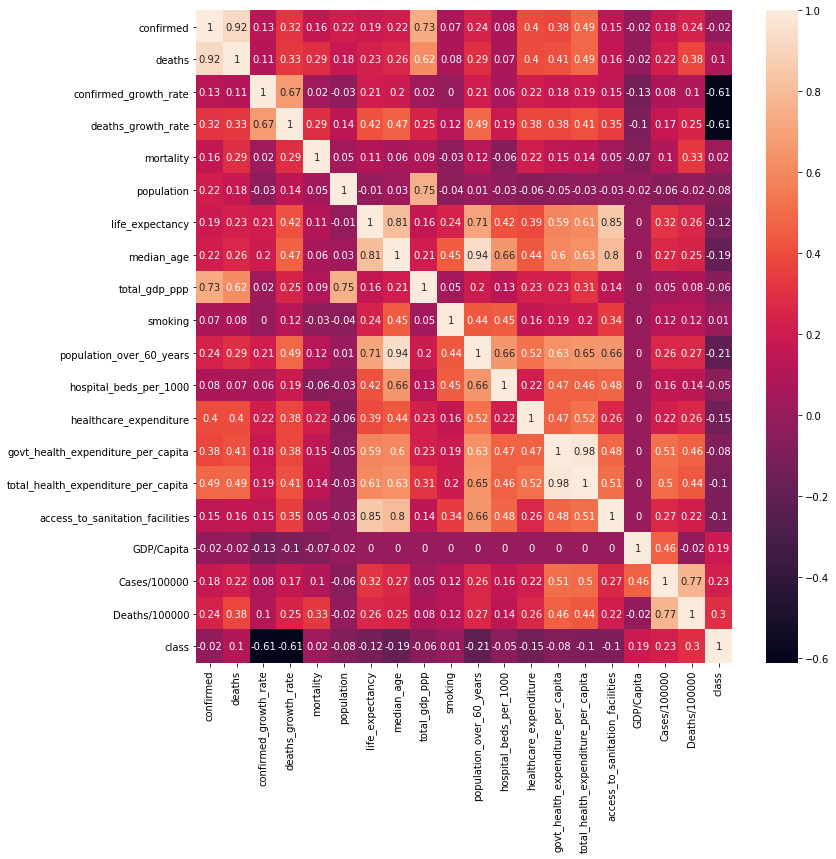

In [22]:
# countries1 = countries.drop(columns = ['confirmed_growth_rate', 'deaths_growth_rate', 'mortality', 'population', 'life_expectancy', 'median_age', 'population_over_60_years', 'access_to_sanitation_facilities'])
# countries2 = countries.drop(columns = ['hospital_beds_per_1000', 'healthcare_expenditure', 'govt_health_expenditure_per_capita', 'total_health_expenditure_per_capita', 'smoking'])

fig_dims = (12, 12)
fig, ax = plt.subplots(figsize=fig_dims)
correlation_matrix = np.around(countries.corr(), 2)
seaborn.heatmap(correlation_matrix, annot=True)
plt.show()


In [23]:
countries.columns

Index(['confirmed', 'deaths', 'confirmed_growth_rate', 'deaths_growth_rate',
       'mortality', 'population', 'life_expectancy', 'median_age',
       'total_gdp_ppp', 'smoking', 'population_over_60_years',
       'hospital_beds_per_1000', 'healthcare_expenditure',
       'govt_health_expenditure_per_capita',
       'total_health_expenditure_per_capita',
       'access_to_sanitation_facilities', 'GDP/Capita', 'Cases/100000',
       'Deaths/100000', 'class'],
      dtype='object')

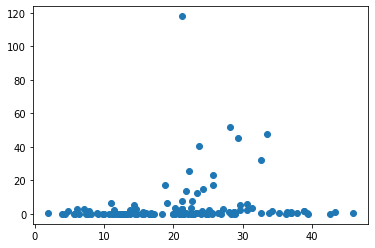

In [24]:
plt.scatter(countries['smoking'], countries['Deaths/100000'])